# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
! pip install split-folders

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
from torchvision import datasets, transforms
import numpy as np
import cv2

from torch.utils.data import Dataset
import splitfolders


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_dir = '/data/landmark_images'

#Train Transform
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomRotation(10),
    transforms.RandomChoice([
            transforms.ColorJitter(hue=0.1),
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

#Test Transform    
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

# Split the training folder    
splitfolders.ratio("/data/landmark_images/train", output="train_valid", seed=1337, ratio=(.8, .2), group_prefix=None)

# Load the Image Data
train_data = datasets.ImageFolder('./train_valid/train', transform=train_transform)
valid_data = datasets.ImageFolder('./train_valid/val', transform=test_transform)
test_data = datasets.ImageFolder('/data/landmark_images/test', transform=test_transform)


# classes names 
n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]

batch_size = 20
# Create data loaders
trainLoader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
validLoader = torch.utils.data.DataLoader(valid_data, batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

loaders_scratch = {'train': trainLoader, 'valid': validLoader, 'test': testLoader}

print('Size of Training dataset:{}\nSize of Validation dataset:{}\nSize of Testing dataset:{}\n'.format(len(train_data), len(valid_data), len(test_data)))


Copying files: 4996 files [00:12, 394.11 files/s]


Size of Training dataset:3996
Size of Validation dataset:1000
Size of Testing dataset:1250



**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: I started with 224x224 images, but after trial and error I moved to 256x256 images.

yes , Data augmentation has been applied on just the training subset of the dataset through random rotations of 10 degrees and random horizontal flips to the images, also with random and different color jitters.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [3]:
def unnormlize(img, s, m):
    return img * s[:, None, None] + m[:, None, None]

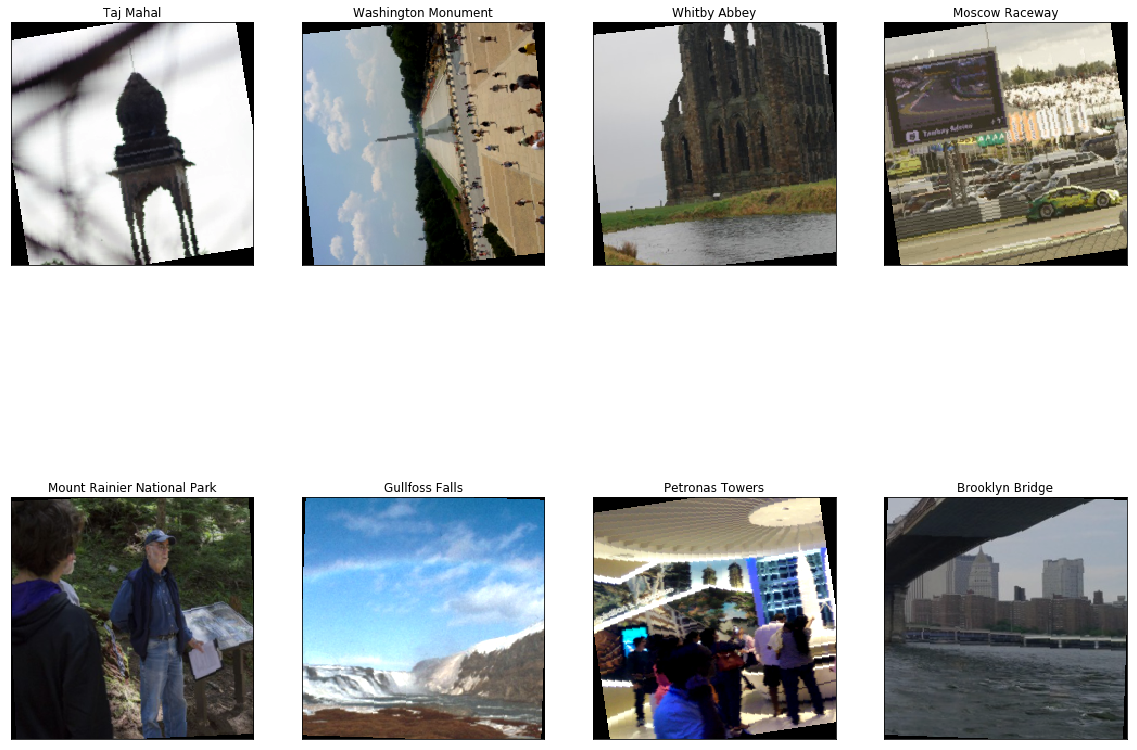

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

fig = plt.figure(figsize=(20,2*8))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[], )
    rand_img = random.randint(0, len(train_data))

    img = unnormlize(train_data[rand_img][0], torch.Tensor(std), torch.Tensor(mean)) 
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) 
    class_name = classes[train_data[rand_img][1]]
    ax.set_title(class_name)

### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## TODO: select loss function
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

criterion_scratch =nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:


# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Max pooling layer (divides image by a factor of 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(28 * 28 * 64, 256)
        self.fc2 = nn.Linear(256, n_classes)
        
        self.dropout = nn.Dropout(0.3)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        self.batch_norm2d = nn.BatchNorm2d(32)
        self.batch_norm1d = nn.BatchNorm1d(256)
        
        
    
    def forward(self, x):
        ## Define forward behavior

        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.batch_norm2d(x)
        x = self.pool(self.leaky_relu(self.conv3(x)))
        
        # Flatten The Image
        x = x.view(-1, 28 * 28 * 64)
        
        # Dropout Layer
        x = self.dropout(x)
        
        # 1st Hidden Layer
        x = self.leaky_relu(self.fc1(x))
        
        x = self.batch_norm1d(x)
        
        # Dropout Layer
        x = self.dropout(x)
        
        # Final Layer
        x = self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [8]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
  (dropout): Dropout(p=0.3)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (batch_norm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm1d): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
    started with a classifier architecture that was present in the original VGG-16 paper as I would have liked to compare my produced model to it, but quickly found out that the dataset provided would not be enough for it to train fully; thus, through trail and error I reduced the number of convolutional layers from 5 to 3 and the cut the number of nodes to accommodate the provided dataset.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print("Model with validation {:.5f} saved".format(valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [10]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.zero_()
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.788846 	Validation Loss: 3.541108
Model with validation 3.54111 saved
Epoch: 2 	Training Loss: 3.522486 	Validation Loss: 3.308250
Model with validation 3.30825 saved
Epoch: 3 	Training Loss: 3.442399 	Validation Loss: 3.262679
Model with validation 3.26268 saved
Epoch: 4 	Training Loss: 3.365732 	Validation Loss: 3.131625
Model with validation 3.13163 saved
Epoch: 5 	Training Loss: 3.264094 	Validation Loss: 2.972997
Model with validation 2.97300 saved
Epoch: 6 	Training Loss: 3.186623 	Validation Loss: 2.949730
Model with validation 2.94973 saved
Epoch: 7 	Training Loss: 3.125745 	Validation Loss: 2.876237
Model with validation 2.87624 saved
Epoch: 8 	Training Loss: 3.092953 	Validation Loss: 2.868626
Model with validation 2.86863 saved
Epoch: 9 	Training Loss: 3.060021 	Validation Loss: 2.855022
Model with validation 2.85502 saved
Epoch: 10 	Training Loss: 3.009219 	Validation Loss: 2.800681
Model with validation 2.80068 saved
Epoch: 11 	Training Loss: 2.9

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs =20  #100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.712908 	Validation Loss: 3.497856
Model with validation 3.49786 saved
Epoch: 2 	Training Loss: 3.532331 	Validation Loss: 3.301949
Model with validation 3.30195 saved
Epoch: 3 	Training Loss: 3.410346 	Validation Loss: 3.189431
Model with validation 3.18943 saved
Epoch: 4 	Training Loss: 3.369226 	Validation Loss: 3.138821
Model with validation 3.13882 saved
Epoch: 5 	Training Loss: 3.289963 	Validation Loss: 3.157156
Epoch: 6 	Training Loss: 3.221969 	Validation Loss: 2.994010
Model with validation 2.99401 saved
Epoch: 7 	Training Loss: 3.170413 	Validation Loss: 2.921164
Model with validation 2.92116 saved
Epoch: 8 	Training Loss: 3.137641 	Validation Loss: 2.883909
Model with validation 2.88391 saved
Epoch: 9 	Training Loss: 3.069634 	Validation Loss: 2.857490
Model with validation 2.85749 saved
Epoch: 10 	Training Loss: 3.054159 	Validation Loss: 2.812759
Model with validation 2.81276 saved
Epoch: 11 	Training Loss: 2.986827 	Validation Loss: 2.868461
Epo

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.391630


Test Accuracy: 40% (507/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
import numpy as np
from glob import glob
import cv2
import matplotlib
import matplotlib.pyplot as plt                        
%matplotlib inline
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import os
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import torch.optim as optim
import math
from torch.utils.data import Dataset

In [14]:
! pip install split-folders

In [15]:
use_cuda = torch.cuda.is_available()

In [16]:
import torch
from torchvision import datasets, transforms
import numpy as np
import cv2

from torch.utils.data import Dataset
import splitfolders


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_dir = '/data/landmark_images'

#Train Transform
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomRotation(10),
    transforms.RandomChoice([
            transforms.ColorJitter(hue=0.1),
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

#Test Transform    
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

# Split the training folder    
splitfolders.ratio("/data/landmark_images/train", output="train_valid", seed=1337, ratio=(.8, .2), group_prefix=None)

# Load the Image Data
train_data = datasets.ImageFolder('./train_valid/train', transform=train_transform)
valid_data = datasets.ImageFolder('./train_valid/val', transform=test_transform)
test_data = datasets.ImageFolder('/data/landmark_images/test', transform=test_transform)


# classes names 
n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]

batch_size = 20
# Create data loaders
trainLoader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
validLoader = torch.utils.data.DataLoader(valid_data, batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

loaders_scratch = {'train': trainLoader, 'valid': validLoader, 'test': testLoader}

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#loaders_transfer = {'train': None, 'valid': None, 'test': None}

loaders_transfer = loaders_scratch


Copying files: 4996 files [00:01, 2642.33 files/s]


In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print("Model with validation {:.5f} saved".format(valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model
  

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [19]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    
    return optimizer
    
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
from torchvision import models

## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)

for parameter in model_transfer.features.parameters():
    parameter.requires_grad = False
    
# Replace The Final Layer With one of your own problem
n_input = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(n_input, n_classes)




#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 111695230.61it/s]


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__
    used the VGG-16 model as a pretrained model because it has been trained on millions of images. Since we have a small dataset and quite similar data, I only replaced the last fully connected layer of the model with one of our own problem to output 50 classes. Additionally, I froze the parameters of all the features layers of the model and left the parameters of the classifier part for training.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [21]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 15


model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.547716 	Validation Loss: 1.488789
Model with validation 1.48879 saved
Epoch: 2 	Training Loss: 1.713380 	Validation Loss: 1.238313
Model with validation 1.23831 saved
Epoch: 3 	Training Loss: 1.522133 	Validation Loss: 1.192964
Model with validation 1.19296 saved
Epoch: 4 	Training Loss: 1.394849 	Validation Loss: 1.083785
Model with validation 1.08379 saved
Epoch: 5 	Training Loss: 1.302336 	Validation Loss: 1.081553
Model with validation 1.08155 saved
Epoch: 6 	Training Loss: 1.250037 	Validation Loss: 1.047487
Model with validation 1.04749 saved
Epoch: 7 	Training Loss: 1.192806 	Validation Loss: 1.037542
Model with validation 1.03754 saved
Epoch: 8 	Training Loss: 1.135569 	Validation Loss: 1.067495
Epoch: 9 	Training Loss: 1.096840 	Validation Loss: 0.997961
Model with validation 0.99796 saved
Epoch: 10 	Training Loss: 1.058349 	Validation Loss: 0.994727
Model with validation 0.99473 saved
Epoch: 11 	Training Loss: 1.023697 	Validation Loss: 0.995235
Epo

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.801711


Test Accuracy: 78% (975/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [23]:
import numpy as np
from glob import glob
import cv2
import matplotlib
import matplotlib.pyplot as plt                        
%matplotlib inline
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import os
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import torch.optim as optim
import math
from torch.utils.data import Dataset

In [24]:
use_cuda = torch.cuda.is_available()

In [25]:

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img = transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    model_transfer.eval()
    output = model_transfer(img)
    top_values, top_idx = output.topk(k)

    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Niagara Falls']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

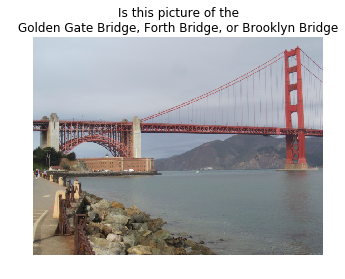

In [26]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    top_k_predictions = predict_landmarks(img_path, 3)
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title('Is this picture of the\n{}, {}, or {}'.format(top_k_predictions[0], top_k_predictions[1], top_k_predictions[2]))
    plt.axis('off')
    plt.show()
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
    The output is better than I expected from only training 20 epoch.
    1- I trained the model for only 20 epoch due to limited time; thus more training time will give me better results.
    2- Hyperparameter tuning: learning rate, optimizer, number of epochs
    3- Experiment with the model architecture, e.g., add more fully connected layers or increase hidden units
    

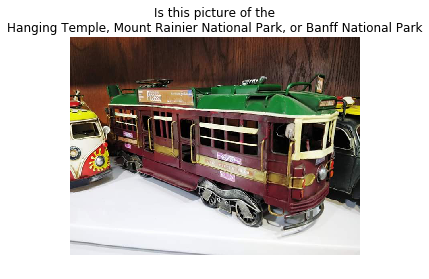

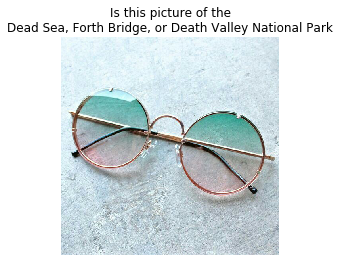

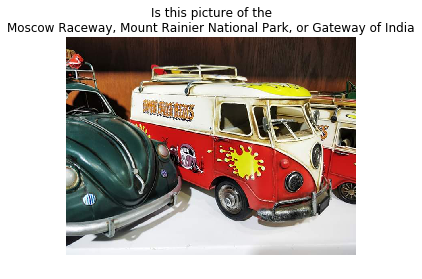

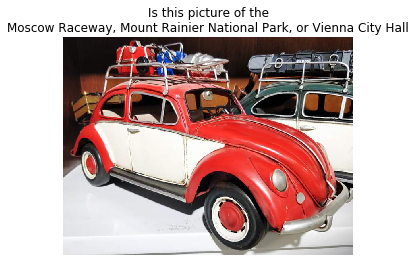

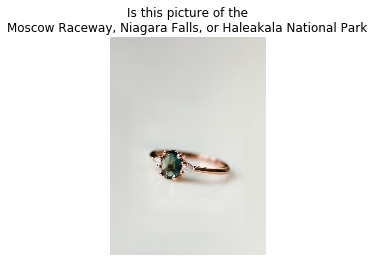

In [30]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import os

for img_path in os.listdir('./test_images'):
    img_path = os.path.join('./test_images', img_path)
    if img_path.lower().endswith(( '.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        suggest_locations(img_path)
